# SSD Price Predictor
### Adrián Bán

Ennek a projektnek a célja az SSD meghajtók tulajdonságaikat tartalmazó adathalmaz alapján megjósolni, hogy adott paraméterek mellett várhatóan mennyibe fog kerülni a termék. Az adatok 2021. április 25-én lettek rögzítve.

Szükséges könyvtárak

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

Adathalmaz

In [2]:
df = pd.read_csv('../data/ssd.csv')

In [3]:
df

,Megnevezés,Méret,Csatlakozás,Technológia,Tároló kapacitás,SSD max írás,SSD max olvasás,TBW,Világítás,Hűtőborda,Ár (FT),Méretek,PCI-e 4.0 SSD
0,"KINGSTON 240GB A400 SATA 3 2.5"" SA400S37/240G","2.5""",SATA 3,TLC,240 GB,350 MB/s,500 MB/s,80 TB,Nem,Nem,11890,NaN,NaN
1,KINGSTON 500GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,500 GB,2000 MB/s,2200 MB/s,300 TB,Nem,Nem,22189,80 x 22 x 3.5 mm,NaN
2,"KINGSTON 480GB A400 SATA 3 2.5"" SA400S37/480G","2.5""",SATA 3,TLC,480 GB,450 MB/s,500 MB/s,160 TB,Nem,Nem,18090,NaN,NaN
3,KINGSTON 250GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,250 GB,1100 MB/s,2000 MB/s,150 TB,Nem,Nem,14489,80 x 22 x 3.5 mm,NaN
4,KINGSTON 1TB A2000 M.2 PCIe M.2 2280 SA2000M8/...,M.2 2280,M.2 PCIe,TLC,1000 GB,2000 MB/s,2200 MB/s,600 TB,Nem,Nem,39590,80 x 22 x 3.5 mm,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,WD 500GB Black SN850 M.2 PCIe M.2 2280 WDBAPY5...,M.2 2280,M.2 PCIe,TLC,500 GB,4100 MB/s,7000 MB/s,300 TB,Nem,Nem,76290,80 x 22 x 2.38 mm,Igen
725,WD 500GB Blue SN550 NVMe M.2 PCIe M.2 2280 WDB...,M.2 2280,M.2 PCIe,TLC,500 GB,1750 MB/s,2400 MB/s,300 TB,Nem,Nem,64690,80 x 22 x 2.38 mm,NaN
726,"ZADAK 128GB TWSS3 SATA 3 2.5"" ZS128GTWSS3-1","2.5""",SATA 3,TLC,128 GB,540 MB/s,560 MB/s,0 TB,Nem,Nem,10690,100 x 69.9 x 7 mm,Nem
727,"ZADAK 256GB TWSS3 SATA 3 2.5"" ZS256GTWSS3-1","2.5""",SATA 3,TLC,256 GB,540 MB/s,560 MB/s,0 TB,Nem,Nem,14089,100 x 69.9 x 7 mm,Nem


Mielőtt elkezdenénk bármit is, érdemes értelmezni a különböző adatokat.

A *Megnevezés*  mező tartalmazza az SSD nevét.

A *Méret* azt, hogy milyen tipusú méret csoportba tartozik.

A *Csatlakozás* azt mondja el, hogy milyen szabványt használ a meghajtó.

A *Tároló kapacítás* az SSD tárhelyét mutatja meg.

Az *SSD max írás* tartalmazza, hogy maximum mekkora sebességgel lehetet adatot írni.

Az *SSD max olvasás* tartalmazza, hogy maximum mekkora sebességgel lehetet adatot olvasni.

A *TBW* a gyártó által megadott maximum írási mennyiség amennyit az SSD elbír.

A *Világítás* azt jelenti rendelkezik-e a termék világítással.

A *Hűtőborda* azt jelenti rendelkezik-e a termék hűtőbordával.

Az *Ár (FT)* a termék ára.

A *Méretek* mutatják meg, hogy a meghajtó milyen fizikai paraméterekkel rendelkezik.

A *PCI-e 4.0 SSD* azt mondja meg, hogy a termék rendelkezik-e ezzel a technológiával.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Megnevezés        729 non-null    object
 1   Méret             729 non-null    object
 2   Csatlakozás       729 non-null    object
 3   Technológia       726 non-null    object
 4   Tároló kapacitás  729 non-null    object
 5   SSD max írás      729 non-null    object
 6   SSD max olvasás   729 non-null    object
 7   TBW               729 non-null    object
 8   Világítás         729 non-null    object
 9   Hűtőborda         729 non-null    object
 10  Ár (FT)           729 non-null    int64 
 11  Méretek           481 non-null    object
 12  PCI-e 4.0 SSD     70 non-null     object
dtypes: int64(1), object(12)
memory usage: 74.2+ KB


## Hiányzó értékek

Hiányzó értékek az adathalmazban

In [5]:
df.isnull().sum()

Megnevezés            0
Méret                 0
Csatlakozás           0
Technológia           3
Tároló kapacitás      0
SSD max írás          0
SSD max olvasás       0
TBW                   0
Világítás             0
Hűtőborda             0
Ár (FT)               0
Méretek             248
PCI-e 4.0 SSD       659
dtype: int64

Százalékos arányban:

In [6]:
percent = ((df['Technológia'].isnull().sum() / df.shape[0]) * 100).round(2)
print(percent, '%')

0.41 %


A *Technológia* mező elhanyagolhatóan kevés hiányzóértéket tartalmaz.

In [7]:
percent = ((df['Méretek'].isnull().sum() / df.shape[0]) * 100).round(2)
print(percent, '%')

34.02 %


A *Méretek* jelentős hiányzó értéket tartalmaz.

In [8]:
percent = ((df['PCI-e 4.0 SSD'].isnull().sum() / df.shape[0]) * 100).round(2)
print(percent, '%')

90.4 %


A *PCI-e 4.0 SSD* mezőnek rengetek értéke hiányzik.

Ezeket a hiányzó értékeket nem lehet benne hagyni az adathalmazban. Különböző módszerek vannak a hiányzó értékek kezelésére, jelenesetben egyszerűen kidobjuk őket.

In [9]:
df_droped = df.drop(['Méretek', 'PCI-e 4.0 SSD'], axis=1) # oszlopokat/mezőket dobjuk ki
df_droped.dropna(inplace=True, axis=0) # sorok/rekordokat dobjuk ki
df_droped.reset_index(drop=True, inplace=True) # index beállítása

In [10]:
df_droped.isnull().sum()

Megnevezés          0
Méret               0
Csatlakozás         0
Technológia         0
Tároló kapacitás    0
SSD max írás        0
SSD max olvasás     0
TBW                 0
Világítás           0
Hűtőborda           0
Ár (FT)             0
dtype: int64

Az adathalmaz már nem tartalmaz *NaN* értékeket.

In [11]:
df_droped.shape

(726, 11)

## Redundáns adatok

In [12]:
len(df[df.duplicated() == True])

0

Az adathalmaz nem tartalmaz ismétlődő sorokat.

## Refaktorálás

A mezők különböző értékei.

In [13]:
for col in df_droped.columns:
    if col != 'Megnevezés' and col != 'Ár (FT)':
        print(col)
        print(df_droped[col].unique())
        print()

Méret
['2.5"' 'M.2 2280' 'mSATA' 'M.2 2242' 'HHHL/PCI Express' 'M.2 2230'
 'M.2 2260' 'Half Slim']

Csatlakozás
['SATA 3' 'M.2 PCIe' 'mSATA' 'M.2 SATA' 'PATA/IDE' 'PCI Express' 'SATA 2']

Technológia
['TLC' 'MLC' 'Optane' 'QLC']

Tároló kapacitás
['240 GB' '500 GB' '480 GB' '250 GB' '1000 GB' '256 GB' '32 GB' '120 GB'
 '960 GB' '512 GB' '2000 GB' '128 GB' '4000 GB' '64 GB' '8000 GB'
 '1920 GB' '3840 GB' '60 GB' '16 GB']

SSD max írás
['350 MB/s' '2000 MB/s' '450 MB/s' '1100 MB/s' '3200 MB/s' '2700 MB/s'
 '650 MB/s' '40 MB/s' '530 MB/s' '500 MB/s' '520 MB/s' '320 MB/s'
 '2300 MB/s' '3300 MB/s' '510 MB/s' '465 MB/s' '380 MB/s' '3000 MB/s'
 '298 MB/s' '5000 MB/s' '1000 MB/s' '950 MB/s' '420 MB/s' '1700 MB/s'
 '2600 MB/s' '430 MB/s' '1925 MB/s' '455 MB/s' '1550 MB/s' '1800 MB/s'
 '460 MB/s' '490 MB/s' '2100 MB/s' '1950 MB/s' '4250 MB/s' '515 MB/s'
 '1600 MB/s' '375 MB/s' '2400 MB/s' '540 MB/s' '1750 MB/s' '1200 MB/s'
 '400 MB/s' '1900 MB/s' '480 MB/s' '300 MB/s' '1500 MB/s' '470 MB/s'
 '41

Láthatóan nincsenenk inkonzisztens adataink, azonban több helyen is numerikus adatokkal szeretnénk számolni a továbbiakban, ezért ezeknek a mezőknek az értékeit formázni kell.

In [14]:
for i in range(df_droped.shape[0]):
    df_droped.loc[i, 'Tároló kapacitás'] = df_droped.loc[i, 'Tároló kapacitás'].replace(' GB', '')
    df_droped.loc[i, 'SSD max írás'] = df_droped.loc[i, 'SSD max írás'].replace(' MB/s', '')
    df_droped.loc[i, 'SSD max olvasás'] = df_droped.loc[i, 'SSD max olvasás'].replace(' MB/s', '')
    df_droped.loc[i, 'TBW'] = df_droped.loc[i, 'TBW'].replace(' TB', '')

df_droped.rename(columns={'Tároló kapacitás': 'Tároló kapacitás (GB)'}, inplace=True)
df_droped.rename(columns={'SSD max írás': 'SSD max írás (MB/s)'}, inplace=True)
df_droped.rename(columns={'SSD max olvasás': 'SSD max olvasás (MB/s)'}, inplace=True)
df_droped.rename(columns={'TBW': 'TBW (TB)'}, inplace=True)

In [15]:
for col in df_droped.columns:
    if col != 'Megnevezés' and col != 'Ár (FT)':
        print(col)
        print(df_droped[col].unique())
        print()

Méret
['2.5"' 'M.2 2280' 'mSATA' 'M.2 2242' 'HHHL/PCI Express' 'M.2 2230'
 'M.2 2260' 'Half Slim']

Csatlakozás
['SATA 3' 'M.2 PCIe' 'mSATA' 'M.2 SATA' 'PATA/IDE' 'PCI Express' 'SATA 2']

Technológia
['TLC' 'MLC' 'Optane' 'QLC']

Tároló kapacitás (GB)
['240' '500' '480' '250' '1000' '256' '32' '120' '960' '512' '2000' '128'
 '4000' '64' '8000' '1920' '3840' '60' '16']

SSD max írás (MB/s)
['350' '2000' '450' '1100' '3200' '2700' '650' '40' '530' '500' '520'
 '320' '2300' '3300' '510' '465' '380' '3000' '298' '5000' '1000' '950'
 '420' '1700' '2600' '430' '1925' '455' '1550' '1800' '460' '490' '2100'
 '1950' '4250' '515' '1600' '375' '2400' '540' '1750' '1200' '400' '1900'
 '480' '300' '1500' '470' '410' '550' '440' '4400' '2500' '2200' '425'
 '1050' '1150' '940' '445' '67' '200' '4100' '1400' '5300' '900' '880'
 '1880' '2900' '1300' '600' '3080' '800' '310' '5100' '6400' '495' '5500'
 '1625' '475' '360' '3100' '850' '485' '205' '1650' '525' '3700' '6550'
 '3950' '0' '523' '2250' '1250'

Végül az adatokat numerikus típussá alakítjuk.

In [16]:
num_cols = ['Tároló kapacitás (GB)', 'SSD max írás (MB/s)', 'SSD max olvasás (MB/s)', 'TBW (TB)']

for col in num_cols:
    df_droped[col] = pd.to_numeric(df_droped[col])

In [17]:
df_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Megnevezés              726 non-null    object
 1   Méret                   726 non-null    object
 2   Csatlakozás             726 non-null    object
 3   Technológia             726 non-null    object
 4   Tároló kapacitás (GB)   726 non-null    int64 
 5   SSD max írás (MB/s)     726 non-null    int64 
 6   SSD max olvasás (MB/s)  726 non-null    int64 
 7   TBW (TB)                726 non-null    int64 
 8   Világítás               726 non-null    object
 9   Hűtőborda               726 non-null    object
 10  Ár (FT)                 726 non-null    int64 
dtypes: int64(5), object(6)
memory usage: 62.5+ KB


A formázás után könnyebben észrevehető, hogy vannak olyan értékek különböző mezőkben, amik bár nem minősülnek hiányzó adatnak, de nincsenek mérve, nincs értékük. Az *SSD max írás (MB/s)*, *SSD max olvasás (MB/s)* és a *TBW (TB)* mezők tartalmaznak 0 értékeket.

Lássuk mennyi értéket tesznek ki az egész adathalmazból.

In [18]:
len(df_droped[df_droped['SSD max írás (MB/s)'] == 0])

6

In [19]:
len(df_droped[df_droped['SSD max olvasás (MB/s)'] == 0])

4

In [20]:
len(df_droped[df_droped['TBW (TB)'] == 0])

224

In [21]:
len(df_droped[(df_droped['SSD max írás (MB/s)'] == 0) | (df_droped['SSD max olvasás (MB/s)'] == 0) | (df_droped['TBW (TB)'] == 0)])

226

A *TBW (TB)* mezőnek számos értéke 0, illetve a többi mezőben is fordulnak elő ilyen értékek. Ezek az értékek ilyen formában rontanak a modell teljesitményén, kezelni kell őket. Jelenesetben kidobjuk ezeket.

In [22]:
indexes = df_droped[(df_droped['SSD max írás (MB/s)'] == 0) | (df_droped['SSD max olvasás (MB/s)'] == 0)].index
df_droped.drop('TBW (TB)', inplace=True, axis=1)
df_droped = df_droped.drop(indexes)
df_droped.reset_index(drop=True, inplace=True)

In [23]:
df_droped.shape

(720, 10)

## Outlierek

<AxesSubplot:>

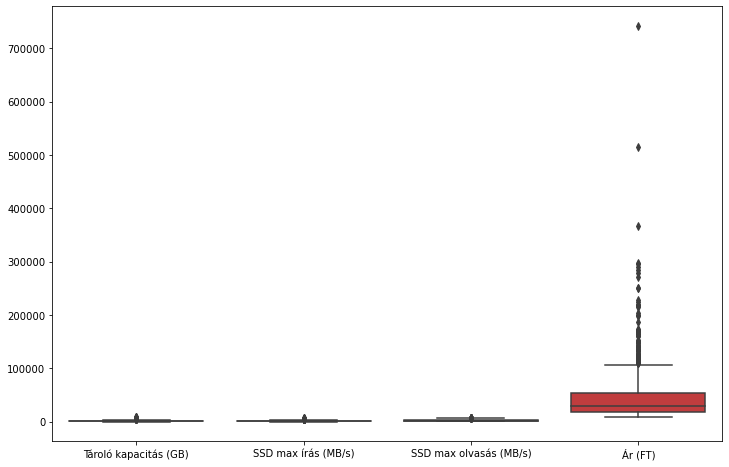

In [24]:
plt.figure(figsize=(12, 8))
num_cols = ['Tároló kapacitás (GB)', 'SSD max írás (MB/s)', 'SSD max olvasás (MB/s)', 'Ár (FT)']
sns.boxplot(data=df_droped[num_cols])

<AxesSubplot:>

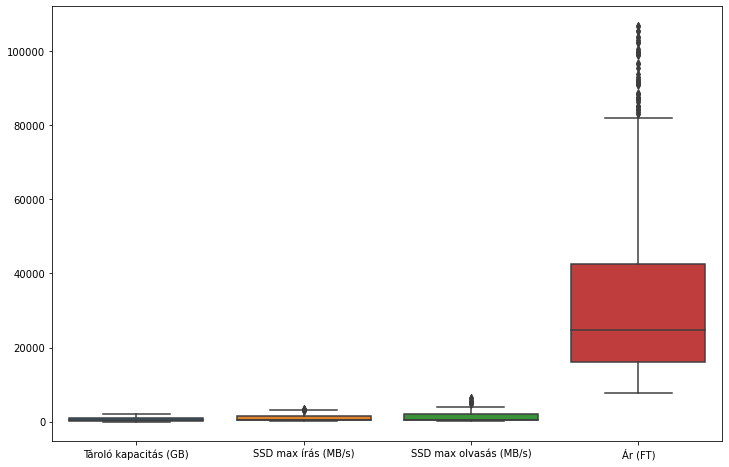

In [25]:
Q1 = df_droped[num_cols].quantile(0.25)
Q3 = df_droped[num_cols].quantile(0.75)
IQR = Q3 - Q1

df_filtered = df_droped[~((df_droped[num_cols] < (Q1 - 1.5 * IQR)) | (df_droped[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

plt.figure(figsize=(12, 8))
sns.boxplot(data=df_filtered[num_cols])

In [26]:
df_filtered.shape

(630, 10)

## Összefüggések

<AxesSubplot:>

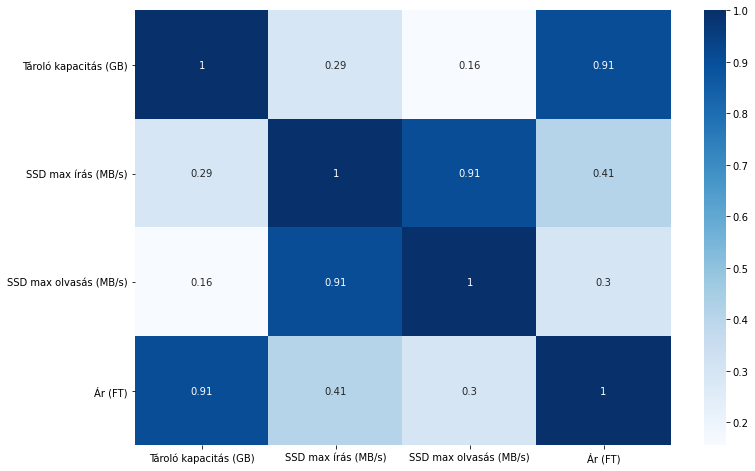

In [27]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_filtered.corr(), annot=True, cmap="Blues")

Erős korreláció fedezhető fel több mező között is.

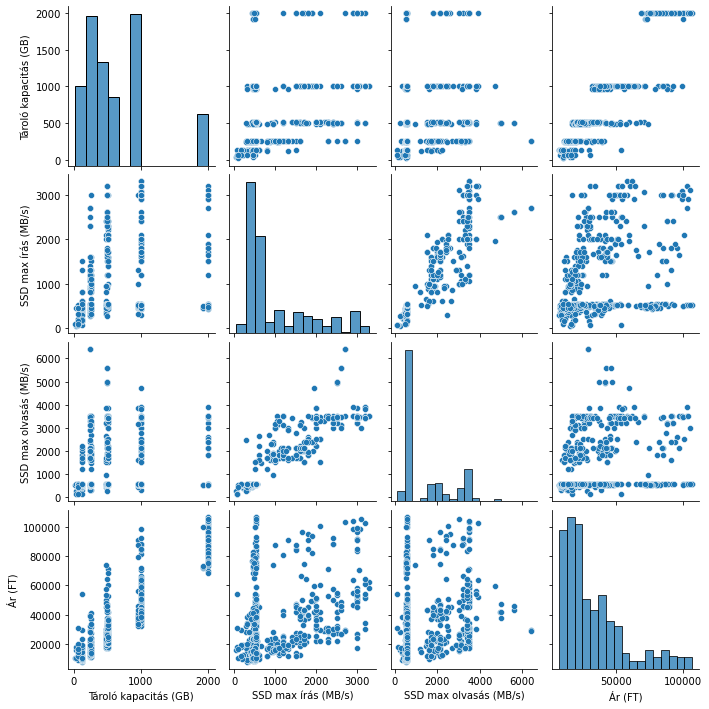

In [28]:
sns.pairplot(data=df_filtered)

## Kategorikus mezők 


In [29]:
df_filtered.head()

,Megnevezés,Méret,Csatlakozás,Technológia,Tároló kapacitás (GB),SSD max írás (MB/s),SSD max olvasás (MB/s),Világítás,Hűtőborda,Ár (FT)
0,"KINGSTON 240GB A400 SATA 3 2.5"" SA400S37/240G","2.5""",SATA 3,TLC,240,350,500,Nem,Nem,11890
1,KINGSTON 500GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,500,2000,2200,Nem,Nem,22189
2,"KINGSTON 480GB A400 SATA 3 2.5"" SA400S37/480G","2.5""",SATA 3,TLC,480,450,500,Nem,Nem,18090
3,KINGSTON 250GB A2000 M.2 PCIe M.2 2280 SA2000M...,M.2 2280,M.2 PCIe,TLC,250,1100,2000,Nem,Nem,14489
4,KINGSTON 1TB A2000 M.2 PCIe M.2 2280 SA2000M8/...,M.2 2280,M.2 PCIe,TLC,1000,2000,2200,Nem,Nem,39590


Kategorikus értékekkel ilyen formában nem lehet számolni. A megoldás *Dummy* változók használata.

In [30]:
X = df_filtered.iloc[:, 1: -1]
y = df_filtered.iloc[:, -1]
y = y.values.reshape(-1, 1)

Jelenesetben *One-hot encoding*-ot használunk.

In [31]:
oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
oh_cols = pd.DataFrame(oh_encoder.fit_transform(X[['Méret', 'Csatlakozás', 'Technológia', 'Világítás', 'Hűtőborda']]))

oh_cols.index = X.index
num_X = X.drop(['Méret', 'Csatlakozás', 'Technológia', 'Világítás', 'Hűtőborda'], axis=1)

oh_X = pd.concat([num_X, oh_cols], axis=1)
oh_X

,Tároló kapacitás (GB),SSD max írás (MB/s),SSD max olvasás (MB/s),0,1,2,3,4,5,6,...,13,14,15,16,17,18,19,20,21,22
0,240,350,500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
1,500,2000,2200,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
2,480,450,500,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
3,250,1100,2000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
4,1000,2000,2200,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,250,1300,1700,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
716,500,1750,2400,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
717,128,540,560,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
718,256,540,560,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## Tanító és teszt halmazra darabolás

In [32]:
X_train, X_test, y_train, y_test = train_test_split(oh_X.values, y, test_size=0.3, random_state=21)

## Standardizálás

In [33]:
sc = StandardScaler()
sc2 = StandardScaler()
X_train[:, :3] = sc.fit_transform(X_train[:, :3])
X_test[:, :3] = sc.transform(X_test[:, :3])
y_train = sc2.fit_transform(y_train)
y_test = sc2.transform(y_test)

## Modellek

### Linear regression

In [34]:
linear = LinearRegression()
linear.fit(X_train, y_train)
results = cross_val_score(estimator=linear, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('linear r2 score: {:.3f}'.format(results.mean()))
print('linear train r2 score: {:.3f}'.format(linear.score(X_train, y_train)))
print('linear test r2 score: {:.3f}'.format(linear.score(X_test, y_test)))

linear r2 score: 0.858
linear train r2 score: 0.881
linear test r2 score: 0.852


Ahogy látható a teszt értéke elég jól közelíti a tanító értéket.

### Decision tree regression

In [35]:
tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)
results = cross_val_score(estimator=tree, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('tree r2 score: {:.3f}'.format(results.mean()))
print('tree train r2 score: {:.3f}'.format(tree.score(X_train, y_train)))
print('tree test r2 score: {:.3f}'.format(tree.score(X_test, y_test)))

tree r2 score: 0.766
tree train r2 score: 0.991
tree test r2 score: 0.767


Itt a modell nagyon jól teljesít a tanító halmazon, viszont teszt halmazon látszik a túltanulás eredménye.

Megpróbálhatunk találni jobb paramétereket, mint amik alpból megvannak adva a modellnek. *(Hyperparameter tuning)*

In [36]:
parameters = {
    'max_depth': [None, 10, 15, 20, 30, 50, 80, 100],
    'max_features': [None, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [1, 2, 8, 10, 12],
}

grid_search = GridSearchCV(estimator = tree,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = 10,
                           return_train_score = True,
                           n_jobs = -1)

grid_search.fit(X_train, y_train.ravel())
best_r2 = grid_search.best_score_
best_parameters = grid_search.best_params_
print()
print("Best r2: {:.2f}".format(best_r2))
print("Best Parameters:", best_parameters)
print()


Best r2: 0.82
Best Parameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 10}



C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan 0.76780087 0.77478134 0.77661856 0.79444468        nan
 0.79200395 0.79576913 0.79712004 0.80676821        nan 0.79423203
 0.79961702 0.80684589 0.80897271        nan 0.80210802 0.80290683
 0.80506824 0.80884515        nan 0.81789585 0.81921804 0.81921804
 0.8178858         nan 0.70505912 0.66870394 0.64462547 0.66259158
        nan 0.57865209 0.57110309 0.63993249 0.61517953        nan
 0.59870789 0.62994569 0.57125556 0.59179391        nan 0.62450082
 0.65710377 0.63494579 0.57831971        nan 0.45104709 0.57513063
 0.52195846 0.55494104        nan 0.62724043 0.7771143  0.76090376
 0.75312195        nan 0.74698047 0.75776133 0.70120911 0.75602799
        nan 0.76777604 0.75821845 0.74906892 0.73388428        nan
 0.75443792 0.69052753 0.79559539 0.77644678        nan 0.69164397
 0.66859937 0.65676025 0.74544494        nan 0.7775104

In [37]:
tree = DecisionTreeRegressor(max_depth=20, max_features=None, min_samples_leaf=5, min_samples_split=10)
tree.fit(X_train, y_train)
results = cross_val_score(estimator=tree, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('tree r2 score: {:.3f}'.format(results.mean()))
print('tree train r2 score: {:.3f}'.format(tree.score(X_train, y_train)))
print('tree test r2 score: {:.3f}'.format(tree.score(X_test, y_test)))

tree r2 score: 0.819
tree train r2 score: 0.903
tree test r2 score: 0.847


### Random forest regression

In [38]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train.ravel())
results = cross_val_score(estimator=forest, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('forest r2 score: {:.3f}'.format(results.mean()))
print('forest train r2 score: {:.3f}'.format(forest.score(X_train, y_train)))
print('forest test r2 score: {:.3f}'.format(forest.score(X_test, y_test)))

forest r2 score: 0.843
forest train r2 score: 0.976
forest test r2 score: 0.858


Itt is jól teljesít a modell a tanító halmazon, viszont a teszt halmazon megint jelentősen rosszabbul.

*Hyperparameter tuning*

In [39]:
parameters = {
    'max_depth': [None, 10, 15, 20, 30, 50],
    'max_features': [None, 5, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [1, 2, 8, 10, 12],
    'n_estimators': [100, 200, 500, 1000]
}

grid_search = GridSearchCV(estimator = forest,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = 10,
                           return_train_score = True,
                           n_jobs = -1)

grid_search.fit(X_train, y_train.ravel())
best_r2 = grid_search.best_score_
best_parameters = grid_search.best_params_
print()
print("Best r2: {:.3f}".format(best_r2))
print("Best Parameters:", best_parameters)
print()

C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.81209526 0.8117071  0.81265789]
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the train scores are non-finite: [       nan        nan        nan ... 0.86026956 0.8592019  0.85975385]
  warnings.warn(



Best r2: 0.849
Best Parameters: {'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}



In [40]:
forest = RandomForestRegressor(n_estimators=100, max_depth=10, max_features=10, min_samples_split=2, min_samples_leaf=1)
forest.fit(X_train, y_train.ravel())
results = cross_val_score(estimator=forest, X=X_test, y=y_test, cv=10, n_jobs=-1)
print('forest r2 score: {:.3f}'.format(results.mean()))
print('forest train r2 score: {:.3f}'.format(forest.score(X_train, y_train)))
print('forest test r2 score: {:.3f}'.format(forest.score(X_test, y_test)))

forest r2 score: 0.796
forest train r2 score: 0.967
forest test r2 score: 0.885


### Support vector regression

In [41]:
svr = SVR()
svr.fit(X_train, y_train.ravel())
results = cross_val_score(estimator=svr, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('svr r2 score: {:.3f}'.format(results.mean()))
print('svr train r2 score: {:.3f}'.format(svr.score(X_train, y_train)))
print('svr test r2 score: {:.3f}'.format(svr.score(X_test, y_test)))

svr r2 score: 0.842
svr train r2 score: 0.876
svr test r2 score: 0.842


Csak mint a lineáris regressziónál, itt sincs nagy eltérés a tanító és teszt érték között.

*Hyperparameter tuning*

In [42]:
parameters = [{'C': [0.25, 0.5, 0.75, 1], 'kernel': ['linear']},
              {'C': [0.25, 0.5, 0.75, 1], 'kernel': ['rbf'], 'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}]

grid_search = GridSearchCV(estimator = svr,
                           param_grid = parameters,
                           scoring = 'r2',
                           cv = 10,
                           return_train_score = True,
                           n_jobs = -1)

grid_search.fit(X_train, y_train.ravel())
print("Best r2: {:.2f}".format(grid_search.best_score_))
print("Best Parameters:", grid_search.best_params_)

Best r2: 0.85
Best Parameters: {'C': 0.5, 'kernel': 'linear'}


In [43]:
svr = SVR(kernel='linear', C=0.5)
svr.fit(X_train, y_train.ravel())
results = cross_val_score(estimator=svr, X=X_train, y=y_train, cv=10, n_jobs=-1)
print('svr r2 score: {:.3f}'.format(results.mean()))
print('svr train r2 score: {:.3f}'.format(svr.score(X_train, y_train)))
print('svr test r2 score: {:.3f}'.format(svr.score(X_test, y_test)))

svr r2 score: 0.853
svr train r2 score: 0.871
svr test r2 score: 0.852


A 4 modell közül a lineáris regresszió és a support vector regression bizonyult a legjobbnak. A továbbiakban a lineáris regressziót használjuk.

## Prediction

Teszteljük a modellt.

In [44]:
size = '2.5"'
connection = 'SATA 3'
tech = 'TLC'
capacity = 512
writing = 540
reading = 560
lights = 'Nem'
cooling = 'Nem'

num_values = sc.transform([[capacity, writing, reading]])
cat_values = oh_encoder.transform(np.array([size, connection, tech, lights, cooling]).reshape(-1, 5))

array = []
for i in num_values:
    for j in i:
        array.append(j)
for i in cat_values:
    for j in i:
        array.append(j)

result = linear.predict([array])
round(sc2.inverse_transform(result)[0][0])

24681

## Adatok és objektumok kimentése publikáláshoz

In [45]:
filenames = ['finalized_model.sav', 'sc_X.sav', 'sc_y.sav', 'oh_enc.sav']
objects = [linear, sc, sc2, oh_encoder]
for i in range(len(filenames)):
    pickle.dump(objects[i], open('../streamlit/' + filenames[i], 'wb'))

df_filtered.to_csv('../streamlit/prepeared_data.csv', index=False, encoding='utf-8')